In [1]:
import logging
import os
import pandas as pd, geopandas as gpd, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from pyomo.environ import *
import networkx as nx
import math
from shapely.geometry import Point
from collections import defaultdict
from scipy.spatial import cKDTree
import seaborn as sns
import contextily as ctx
from collections import defaultdict
from shapely.geometry import Point
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

In [2]:
# os.chdir(r"C:\Users\omkarp\Downloads\Opti\halfHour")
shapefileDemands = "full/demandHexGrid.shp"
csv_distance_path = "full/shortestpath.csv"
spotPrices = 'ElPrice.csv'
parking   = "full/CharParkfull.shp"

# shapefileDemands="small/smallHexGrid.shp"
# parking="small/CharParkSmall.shp"
# csv_distance_path="small/shortestSmall.csv"
# spotPrices = "ElPrice.csv"
# gdf = gpd.read_file(shapefileDemands)
df = pd.read_csv(spotPrices)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hour    24 non-null     int64  
 1   Jan     24 non-null     float64
 2   Feb     24 non-null     float64
 3   Mar     24 non-null     float64
 4   Apr     24 non-null     float64
 5   May     24 non-null     float64
 6   Jun     24 non-null     float64
 7   Jul     24 non-null     float64
 8   Aug     24 non-null     float64
 9   Sep     24 non-null     float64
 10  Oct     24 non-null     float64
 11  Nov     24 non-null     float64
 12  Dec     24 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 2.6 KB


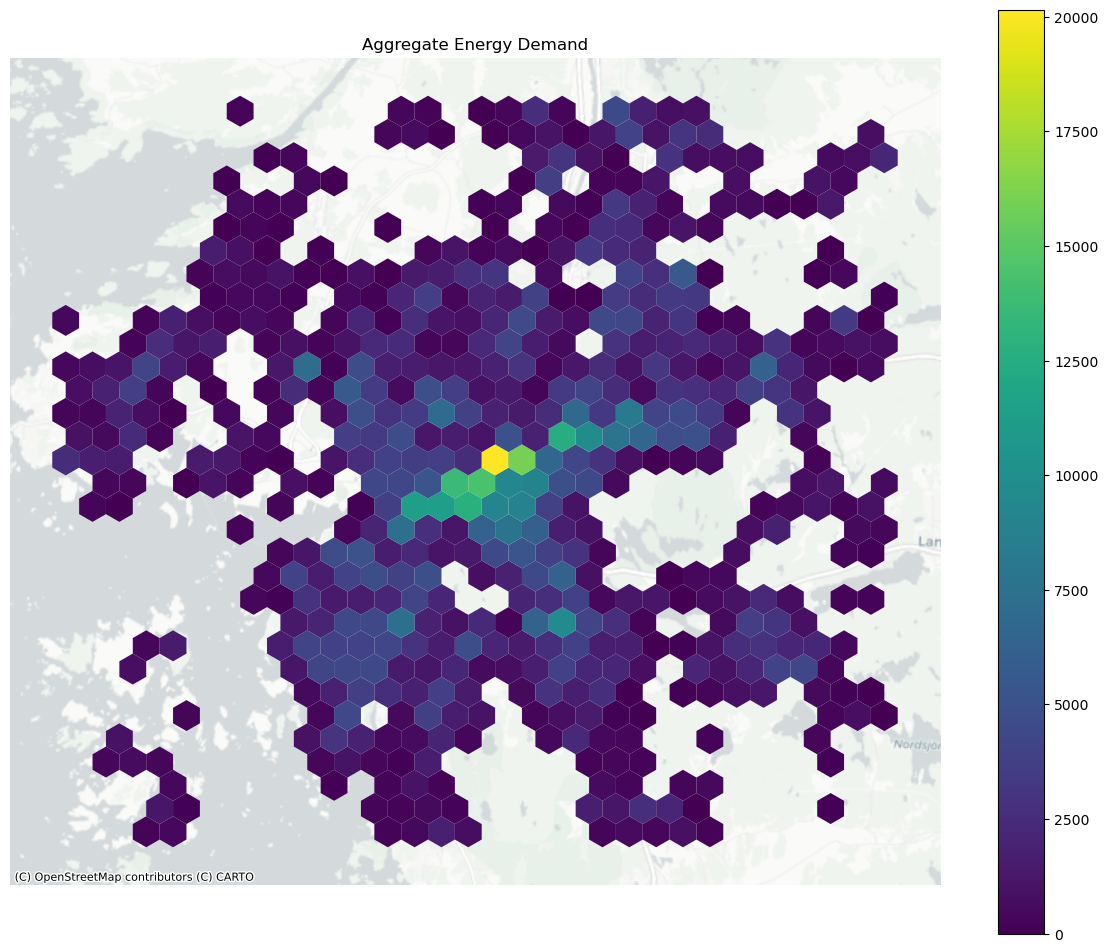

In [8]:
complete_gdf = gpd.read_file(shapefileDemands)
agg_demand = complete_gdf.groupby('HexID').agg({'Demand': 'sum'}).reset_index()
hex_geometry = complete_gdf[['HexID', 'geometry']].drop_duplicates(subset='HexID')
agg_demand = pd.merge(agg_demand, hex_geometry, on='HexID', how='left')
agg_demand = gpd.GeoDataFrame(agg_demand, geometry='geometry', crs=complete_gdf.crs)
fig, ax = plt.subplots(figsize=(15, 12))
agg_demand.plot(column='Demand', ax=ax, cmap='viridis', legend=True)
ctx.add_basemap(ax, crs=complete_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_title("Aggregate Energy Demand")
ax.set_axis_off()
plt.savefig("AggDemand.png", dpi=1200, bbox_inches="tight")
plt.show()

# Results

In [10]:
def sv(obj, default=0.0):
    try:
        v = obj.value                  
        return default if v is None else float(v)
    except AttributeError:
        try:
            return float(value(obj))     
        except Exception:
            return default

DAYS          = sum(N_MONTH.values())               # 365
PUB_PRICE_MIN = min(value(model.Price[c]) for c in model.C_pub)
tot_chargers   = {c: sum(sv(model.x[i, c]) for i in model.I) for c in model.C_pub}
tot_PV_panels  = sum(sv(model.PV  [i]) for i in model.I)
tot_Batt_cells = sum(sv(model.Batt[i]) for i in model.I)
ann_grid_direct = sum(N_MONTH[m]*sv(model.grid_dir [i,m,t])
                      for i in model.I for m in model.M for t in model.H)
ann_grid_batt   = sum(N_MONTH[m]*sv(model.grid_batt[i,m,t])
                      for i in model.I for m in model.M for t in model.H)
ann_grid_total  = ann_grid_direct + ann_grid_batt

ann_pv_direct = sum(N_MONTH[m]*sv(model.pv_dir [i,m,t])
                    for i in model.I for m in model.M for t in model.H)
ann_pv_batt   = sum(N_MONTH[m]*sv(model.pv_batt[i,m,t])
                    for i in model.I for m in model.M for t in model.H)
ann_pv_total  = ann_pv_direct + ann_pv_batt

ann_redir      = sum(N_MONTH[m]*sv(model.z[i,j,m,t])
                    for (i,j,m,t) in model.A)

avg_soc = (
    sum(N_MONTH[m]*sv(model.soc[i,m,t])
        for i in model.I for m in model.M for t in model.H)
    / (len(model.I)*len(model.H)*DAYS)
)

rev_total = sum(N_MONTH[m]*value(model.Price[c])*sv(model.edisp[i,m,t,c,b])
                for i in model.I for m in model.M for t in model.H
                for b in model.B for c in eligible[b])
rev_redir = PUB_PRICE_MIN * ann_redir

grid_cost = (
      sum(N_MONTH[m]*sv(model.tou[m,t])*sv(model.grid_dir [i,m,t])
          for i in model.I for m in model.M for t in model.H)
    + sum(N_MONTH[m]*sv(model.tou[m,t])*sv(model.grid_batt[i,m,t])
          for i in model.I for m in model.M for t in model.H)
)

redir_cost = sum(N_MONTH[m]*sv(model.T[i,j])*sv(model.n_trip[i,j,m,t])
                 for (i,j,m,t) in model.A)

slack_pen  = penalty_per_kWh * sum(
                 N_MONTH[m]*sv(model.slack[i,m,t,b])
                 for i in model.I for m in model.M for t in model.H for b in model.B)

capex_chargers = DAYS * sum(
    sv(model.PVF_cost[c]) * sv(model.x[i,c])
    for i in model.I for c in model.C_pub
)
capex_energy   = DAYS * sum(
      sv(model.PVF_PV)   * sv(model.PV  [i])
    + sv(model.PVF_Batt) * sv(model.Batt[i])
    for i in model.I
)

slack_rows = [(i,m,t,b, sv(model.slack[i,m,t,b]))
              for i in model.I for m in model.M for t in model.H for b in model.B
              if sv(model.slack[i,m,t,b]) > 1e-6]
df_slack = pd.DataFrame(slack_rows,
                        columns=["HexID","Month","TimeIdx","Class","Slack_kWh"])

print(f"\n================  OPTIMAL ANNUAL PROFIT  ================\n"
      f"Total profit : {sv(model.obj):,.0f}  SEK / yr\n")

print("==================  BREAKDOWN  =================")
print(f"Revenue (all chargers)        : {rev_total:>13,.0f}")
print(f"  – share from redirected cars : {rev_redir:>13,.0f}")
print(f"Opex    – grid purchases      : {grid_cost:>13,.0f}")
print(f"Opex    – redirection cost    : {redir_cost:>13,.0f}")
print(f"Opex    – unmet-demand pen.   : {slack_pen:>13,.0f}")
print(f"Capex   – chargers            : {capex_chargers:>13,.0f}")
print(f"Capex   – PV & batteries      : {capex_energy:>13,.0f}")
print("")
print(f"Optimal annual profit         : {sv(model.obj):>13,.0f} SEK/yr")
print("==========================================================\n")

print("- Installed infrastructure -")
for c,n in tot_chargers.items():
    if n: print(f"  {c.capitalize():<6} chargers : {n:>10,.0f} units")
print(f"  PV panels      : {tot_PV_panels:>10,.0f} units")
print(f"  Battery cells  : {tot_Batt_cells:>10,.0f} units\n")

print("- Annual energy flows (kWh) -")
print(f"  Grid purchased (direct)     : {ann_grid_direct:>12,.1f}")
print(f"  Grid → battery charging     : {ann_grid_batt:>12,.1f}")
print(f"  Total grid energy           : {ann_grid_total:>12,.1f}\n")
print(f"  PV used directly            : {ann_pv_direct:>12,.1f}")
print(f"  PV → battery charging       : {ann_pv_batt:>12,.1f}")
print(f"  Total PV generated & used   : {ann_pv_total:>12,.1f}\n")
print(f"  Energy redirected           : {ann_redir:>12,.1f}")
print(f"  Average battery SOC (kWh)   : {avg_soc:>12,.2f}\n")

if df_slack.empty:
    print("✅  All representative-day demand was met (no slack).")
else:
    print("⚠️  Unmet demand (first 8 rows):")
    print(df_slack.head(8).to_string(index=False))
    slack_yr = sum(N_MONTH[r.Month]*r.Slack_kWh for r in df_slack.itertuples())
    print(f"\nTotal annual slack (kWh): {slack_yr:,.1f}")

print("\n==========================================================\n")

soc_jan1  = {i: sv(model.soc[i,'January',1])               for i in model.I}
soc_dec48 = {i: sv(model.soc[i,'December',max(model.H)])   for i in model.I}
max_gap   = max(abs(soc_dec48[i] - soc_jan1[i]) for i in model.I)
print(f"Max |ΔSOC| Jan→Dec : {max_gap:.4f} kWh")
print("✅  Annual SOC cycle closes." if max_gap < 1e-3
      else "⚠️  Annual SOC cycle not tight!")

HOME_KWH_PER_SLOT = charger_capacity["home"]      # 3.5 kWh/30‑min
SLOTS_PER_DAY     = len(INTERVALS)
tot_home_chargers = sum(home_avail.values())

home_base = (gdf.query("charType.str.lower() == 'home'")
               .groupby(["HexID","TimeIndex"])["Demand"]
               .sum().to_dict())

served_by_home = 0.0
for i in HexIDs:
    cap_i = home_avail[i] * HOME_KWH_PER_SLOT
    for t in time_indices:
        served_by_home += min(home_base.get((i, t), 0.0), cap_i) * DAYS

theor_supplied = (tot_home_chargers * HOME_KWH_PER_SLOT *  SLOTS_PER_DAY * DAYS)
util_pct = 100 * served_by_home / theor_supplied if theor_supplied else 0.0
energy_pub = {c: 0.0 for c in ["slow", "medium", "fast"]}
for i in model.I:
    for m in model.M:
        nd = N_MONTH[m]
        for t in model.H:
            for c in model.C:      # slow / medium / fast
                for b in model.B:  # home or public demand
                    energy_pub[c] += nd * value(model.edisp[i, m, t, c, b])

slack_energy = 0.0
for i in model.I:
    for m in model.M:
        nd = N_MONTH[m]
        for t in model.H:
            for b in model.B:
                slack_energy += nd * value(model.slack[i, m, t, b])

total_supply = served_by_home + sum(energy_pub.values())
total_demand = total_supply + slack_energy    # slack = unmet demand

print("\n================  HOME‑CHARGER OVERVIEW  ================")
print(f"Installed home chargers : {tot_home_chargers:>11,d} units")
print(f"Potential energy output  : {theor_supplied:>11,.0f}  kWh / yr")
print(f"Energy actually supplied : {served_by_home:>11,.0f}  kWh / yr")
print(f"  – Utilisation          : {util_pct:>10.1f}  %")
print(f"Home demand met by homes : {served_by_home:>11,.0f}  kWh / yr")

print("\n================  PUBLIC‑CHARGER SUPPLY  ================")
for c in ["slow", "medium", "fast"]:
    print(f"Energy via {c:<6} chargers : {energy_pub[c]:>11,.0f}  kWh / yr")

print("\n================  SYSTEM BALANCE  =======================")
print(f"Total demand (model)     : {total_demand:>11,.0f}  kWh / yr")
print(f"Total energy supplied    : {total_supply:>11,.0f}  kWh / yr")
print(f"Unserved demand (slack)  : {slack_energy:>11,.0f}  kWh / yr")

if abs(total_supply - total_demand) < 1e-3: print("✔  Energy balance closes: SUPPLY = DEMAND")
else: print("✖  Energy imbalance detected!")
print("==========================================================\n")


================  OPTIMAL ANNUAL PROFIT  ================
Total profit : 1,092,806,466  SEK / yr

==================  BREAKDOWN  =================
Revenue (all chargers)        : 1,478,088,003
  – share from redirected cars :     5,284,282
Opex    – grid purchases      :   332,587,969
Opex    – redirection cost    :     1,655,865
Opex    – unmet-demand pen.   :             0
Capex   – chargers            :    16,765,416
Capex   – PV & batteries      :    34,272,287
----------------------------------------------------------
Optimal annual profit         : 1,092,806,466 SEK/yr

----- Installed infrastructure -----
  Slow   chargers :        283 units
  Medium chargers :      7,186 units
  Fast   chargers :         11 units
  PV panels      :     88,810 units
  Battery cells  :        731 units

----- Annual energy flows (kWh) -----
  Grid purchased (direct)     : 191,494,367.9
  Grid → battery charging     :    534,343.2
  Total grid energy           : 192,028,711.1

  PV used directly 

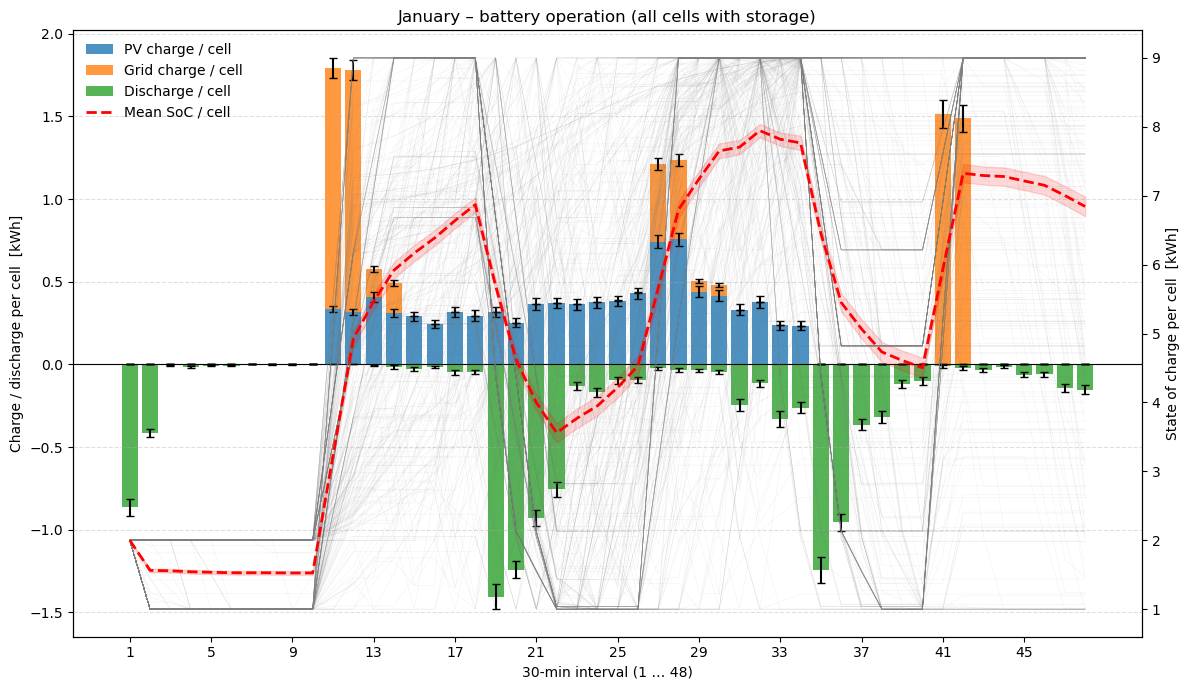

In [5]:
output_filename = "OptiFull.xlsx"
month     = "January"           
cell_kwh  = 10.0               
df_batt   = pd.read_excel(output_filename, sheet_name="Battery Details")

df_batt = (df_batt.loc[df_batt["Month"] == month]
                    .copy())
df_batt["Num_Cells"] = df_batt["Installed_kWh"] / cell_kwh
df_batt = df_batt[df_batt["Num_Cells"] > 0]
df_batt["SoC_pc"]     = df_batt["State_of_Charge_kWh"] / df_batt["Num_Cells"]
df_batt["Ch_PV_pc"]   = df_batt["Charge_from_PV_kWh"]  / df_batt["Num_Cells"]
df_batt["Ch_Grid_pc"] = df_batt["Charge_from_Grid_kWh"]/ df_batt["Num_Cells"]
df_batt["Dis_pc"]     = df_batt["Discharge_kWh"]       / df_batt["Num_Cells"]

grp = df_batt.groupby("TimeIndex")
stats = pd.DataFrame({
    "μ_PV"  : grp["Ch_PV_pc"  ].mean(),
    "e_PV"  : grp["Ch_PV_pc"  ].std() / np.sqrt(grp.size()),
    "μ_G"   : grp["Ch_Grid_pc"].mean(),
    "e_G"   : grp["Ch_Grid_pc"].std() / np.sqrt(grp.size()),
    "μ_D"   : grp["Dis_pc"    ].mean(),
    "e_D"   : grp["Dis_pc"    ].std() / np.sqrt(grp.size()),
    "μ_SoC" : grp["SoC_pc"    ].mean(),
    "e_SoC" : grp["SoC_pc"    ].std() / np.sqrt(grp.size()),
})
x = stats.index.values   

fig, ax1 = plt.subplots(figsize=(12,7))
ax2 = ax1.twinx()

# stacked charge bars (positive)  & discharge (negative)
base = np.zeros_like(x, dtype=float)
ax1.bar(x, stats["μ_PV"],bottom=base, yerr=stats["e_PV"],label="PV charge / cell",alpha=0.8, capsize=3)
base += stats["μ_PV"]
ax1.bar(x, stats["μ_G"], bottom=base, yerr=stats["e_G"], label="Grid charge / cell",  alpha=0.8, capsize=3)
ax1.bar(x, -stats["μ_D"],bottom=0, yerr=stats["e_D"], label="Discharge / cell",    alpha=0.8, capsize=3)
ax1.set_xlabel("30-min interval (1 … 48)")
ax1.set_ylabel("Charge / discharge per cell  [kWh]")

# individual SoC traces (grey) + mean SoC on secondary axis
for _, g in df_batt.groupby("HexID"):
    ax2.plot(g["TimeIndex"], g["SoC_pc"],
             lw=0.4, alpha=0.1, color="grey")
ax2.plot(x, stats["μ_SoC"], color="red", lw=2, ls="", label="Mean SoC / cell")
ax2.fill_between(x,
                 stats["μ_SoC"]-stats["e_SoC"],
                 stats["μ_SoC"]+stats["e_SoC"],
                 color="red", alpha=0.15)
ax2.set_ylabel("State of charge per cell  [kWh]")
ax1.axhline(0, color="black", lw=0.8)
ax1.set_xticks(range(1, 49, 4))
ax1.grid(axis="y", ls="", alpha=0.4)
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, frameon=False, loc="upper left")
plt.title(f"{month} – battery operation (all cells with storage)")
plt.tight_layout()
plt.savefig(f"2July_BatteryFull_{month}.png", dpi=300, bbox_inches="tight")
plt.show()

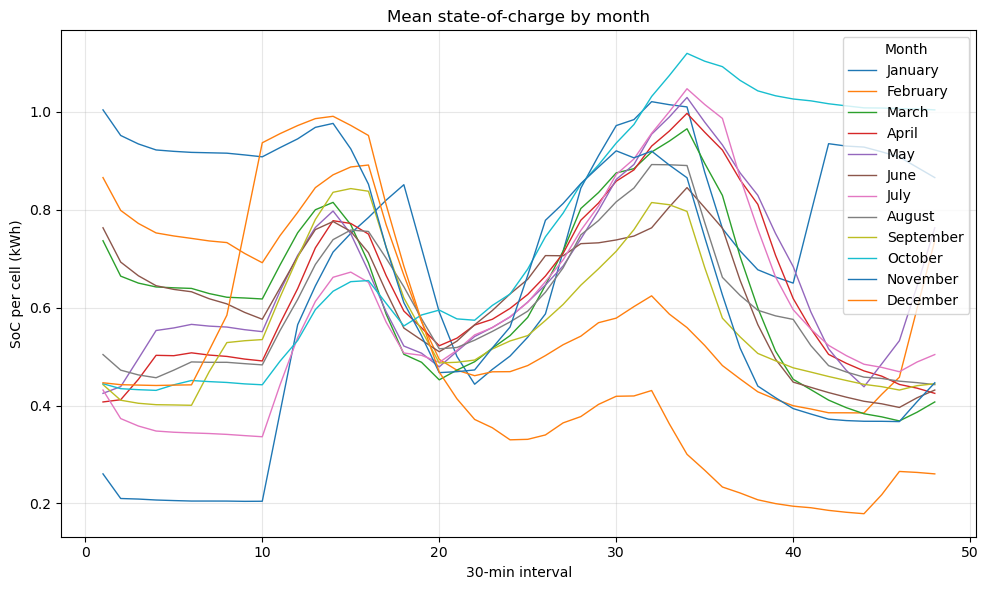

In [7]:
output_filename = "OptiFull.xlsx"
df_batt = pd.read_excel(output_filename, sheet_name="Battery Details")
cap_per_cell = 10.0  # kWh per cell
df_batt = df_batt.copy()
df_batt["SoC_per_cell"] = df_batt["State_of_Charge_kWh"] / cap_per_cell
soc = (
    df_batt
      .groupby(["Month", "TimeIndex"])["SoC_per_cell"]
      .mean()
      .unstack("Month")
)
# MONTHS = ['January', 'March','May','July','September','November']
MONTHS = ['January','February','March','April','May','June','July','August','September','October','November','December']
soc = soc.reindex(columns=MONTHS)
fig, ax = plt.subplots(figsize=(10, 6))
soc.plot(ax=ax, linewidth=1)
ax.set(
    xlabel="30-min interval",
    ylabel="SoC per cell (kWh)",
    title="Mean state-of-charge by month"
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

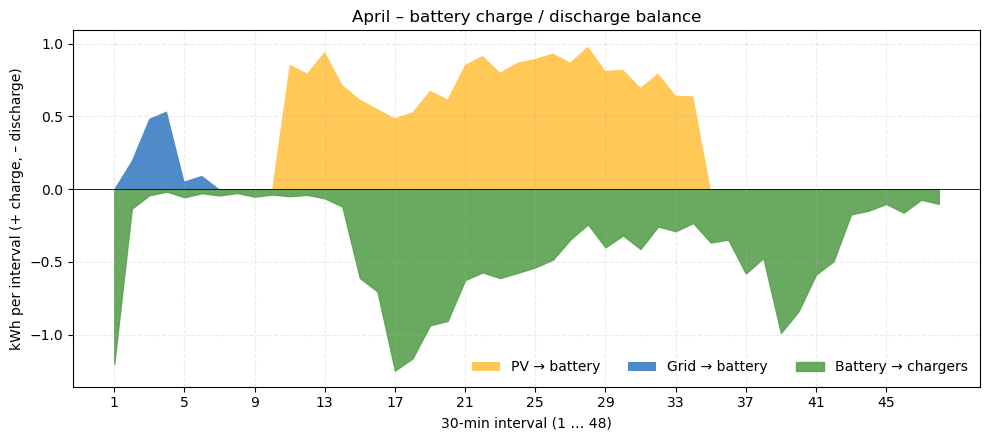

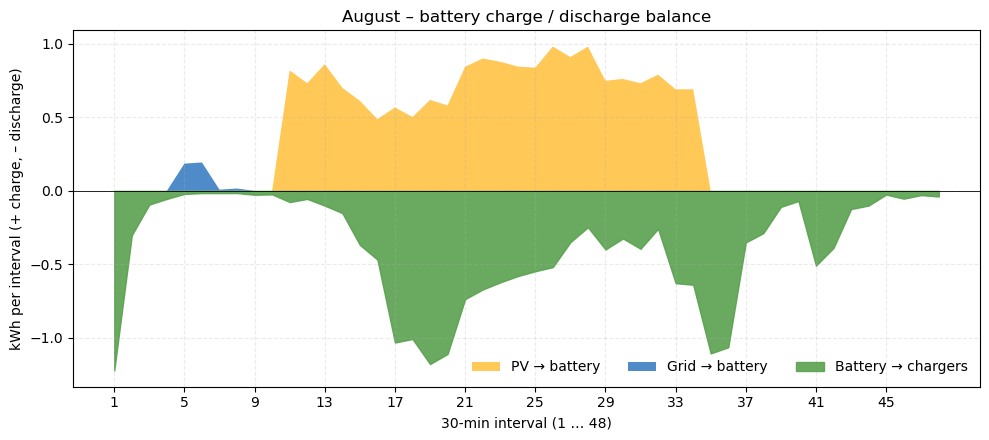

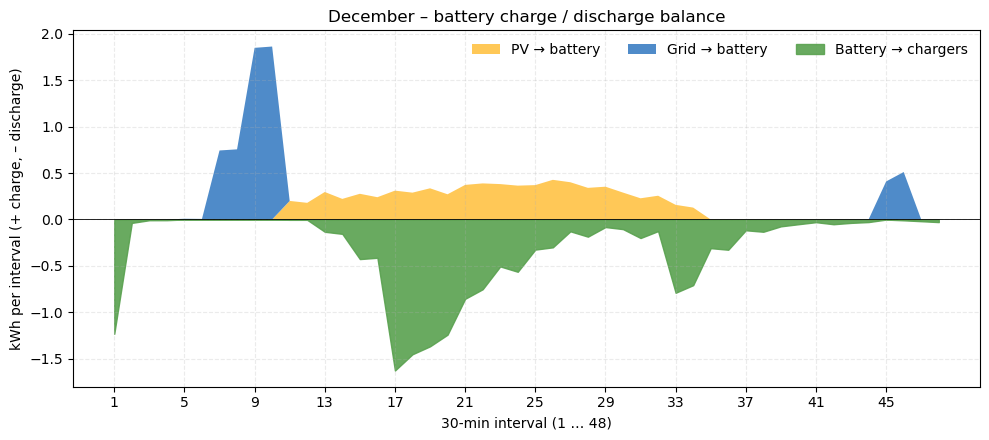

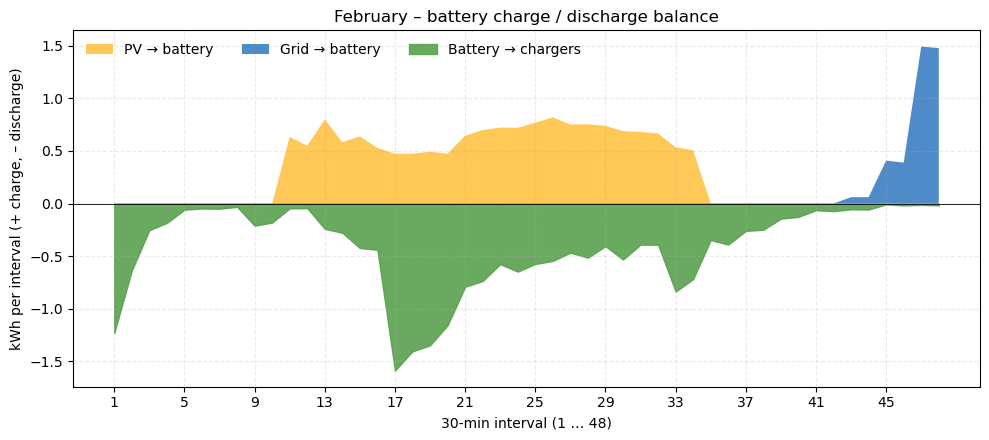

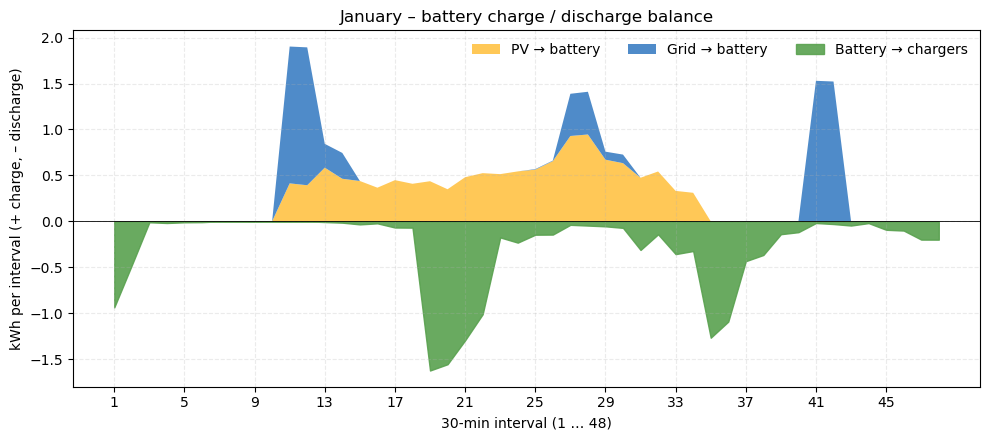

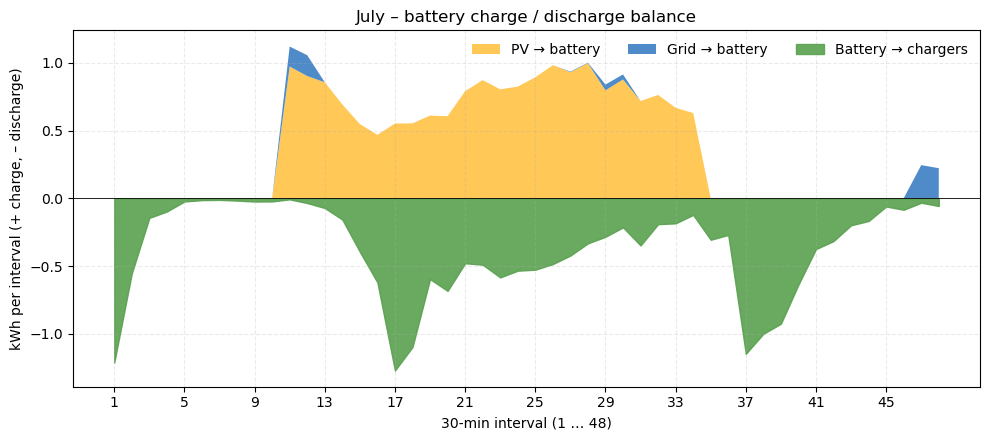

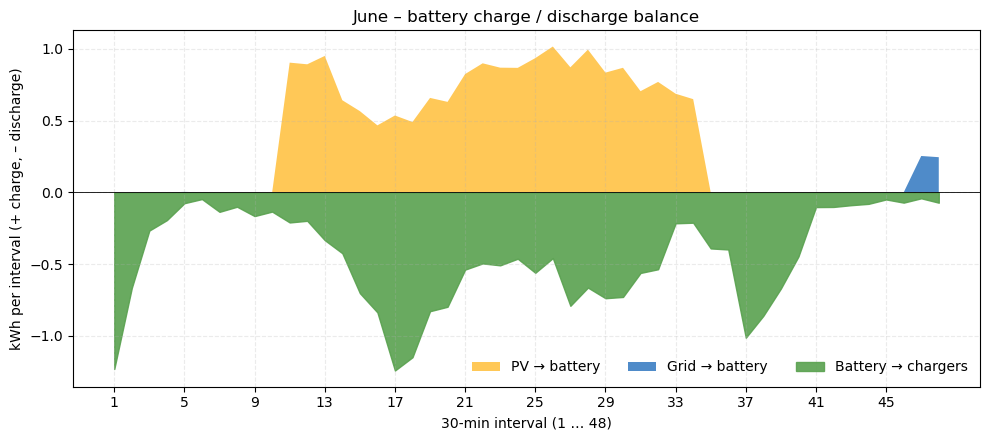

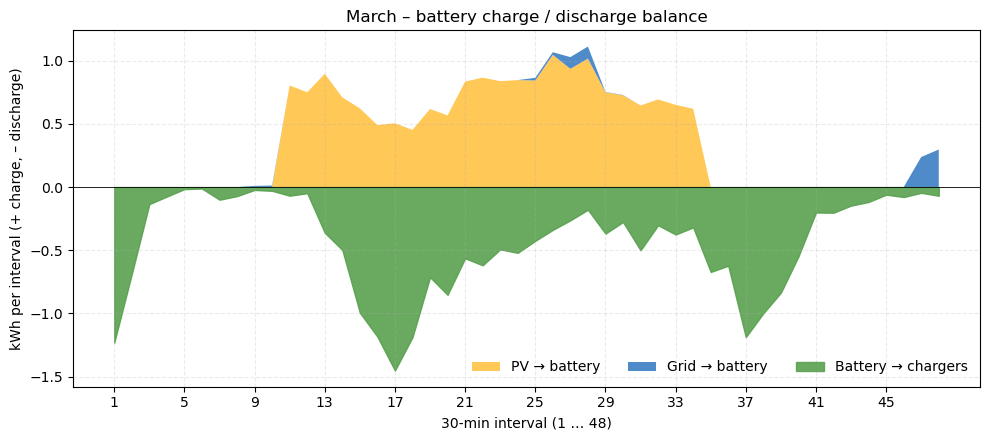

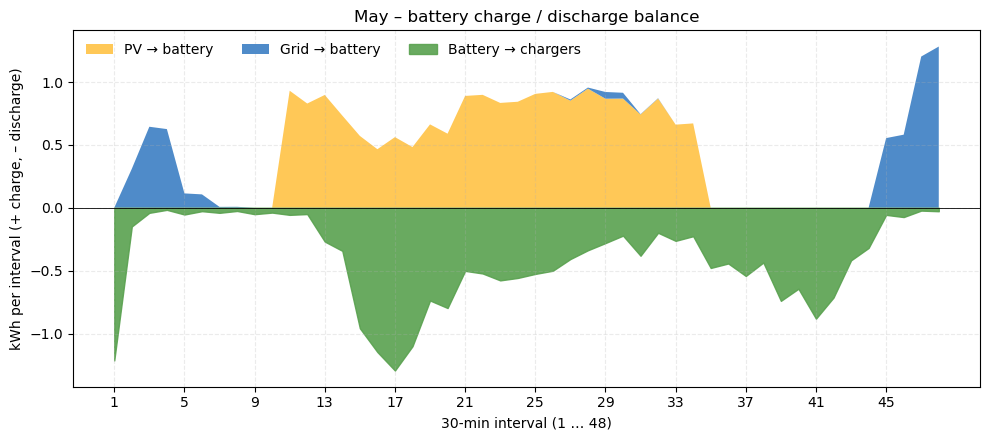

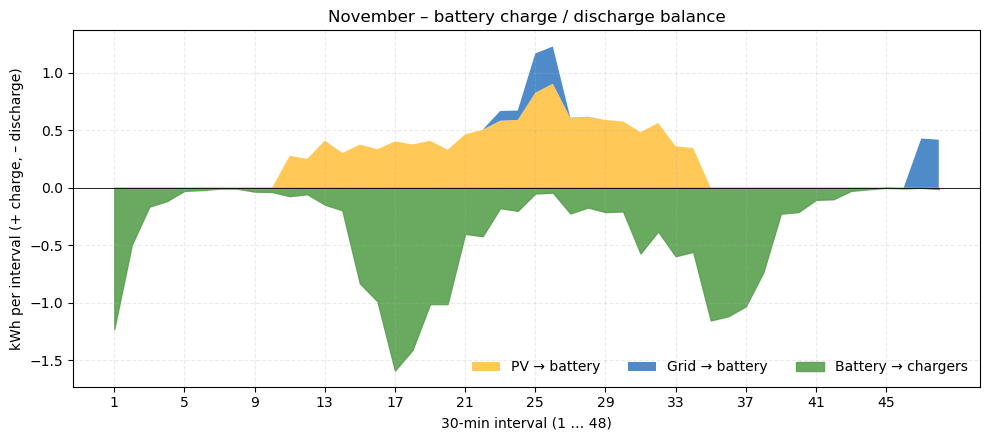

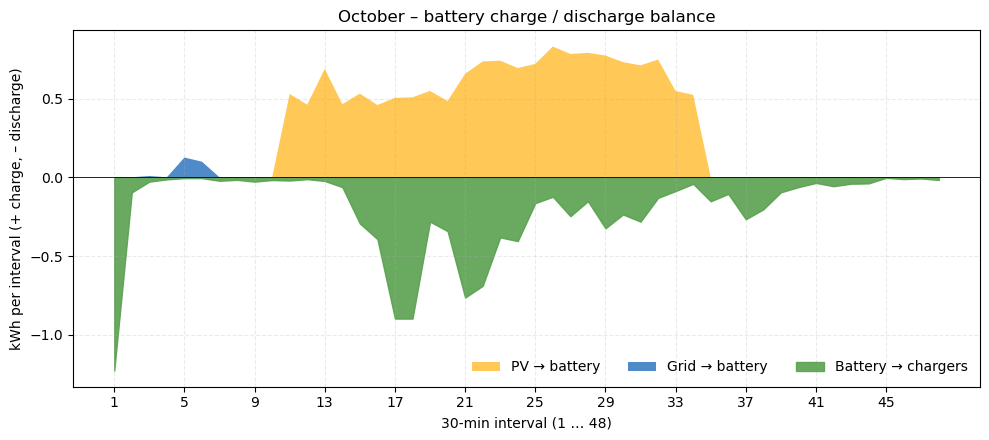

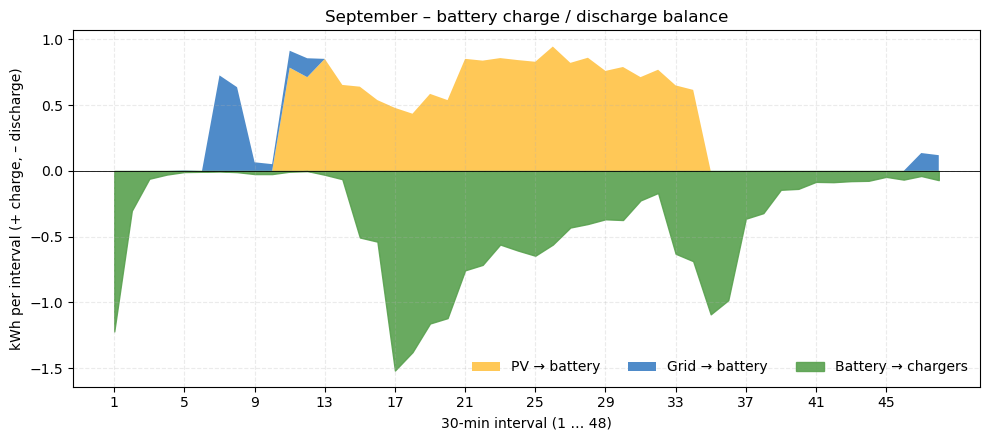

In [8]:
#  Battery-flow balance by month
df_batt = pd.read_excel(output_filename, sheet_name="Battery Details")
agg = (df_batt
       .groupby(["Month", "TimeIndex"])
       [["Charge_from_PV_kWh",
         "Charge_from_Grid_kWh",
         "Discharge_kWh"]]
       .mean()        
       .reset_index())

cols = {"pv":"#FFC857", "grid":"#4F8BC9", "dis":"#59A14F"}

for month, grp in agg.groupby("Month", sort=False):
    x   = grp["TimeIndex"]
    pv  =  grp["Charge_from_PV_kWh"]              # +ve
    grd =  grp["Charge_from_Grid_kWh"]            # +ve
    dis = -grp["Discharge_kWh"]                   # plot below zero

    fig, ax = plt.subplots(figsize=(10,4.5))

    ax.stackplot(x, pv, grd,
                 labels=["PV → battery", "Grid → battery"],
                 colors=[cols["pv"], cols["grid"]], linewidth=0)

    ax.fill_between(x, 0, dis,
                    label="Battery → chargers",
                    color=cols["dis"], alpha=.9)

    ax.axhline(0, color="black", lw=.6)
    ax.set(
        xlabel="30-min interval (1 … 48)",
        ylabel="kWh per interval (+ charge, – discharge)",
        title=f"{month} – battery charge / discharge balance"
    )
    ax.set_xticks(range(1,49,4))
    ax.legend(frameon=False, ncol=3)
    ax.grid(alpha=.25, linestyle="")
    plt.tight_layout()
    plt.show()

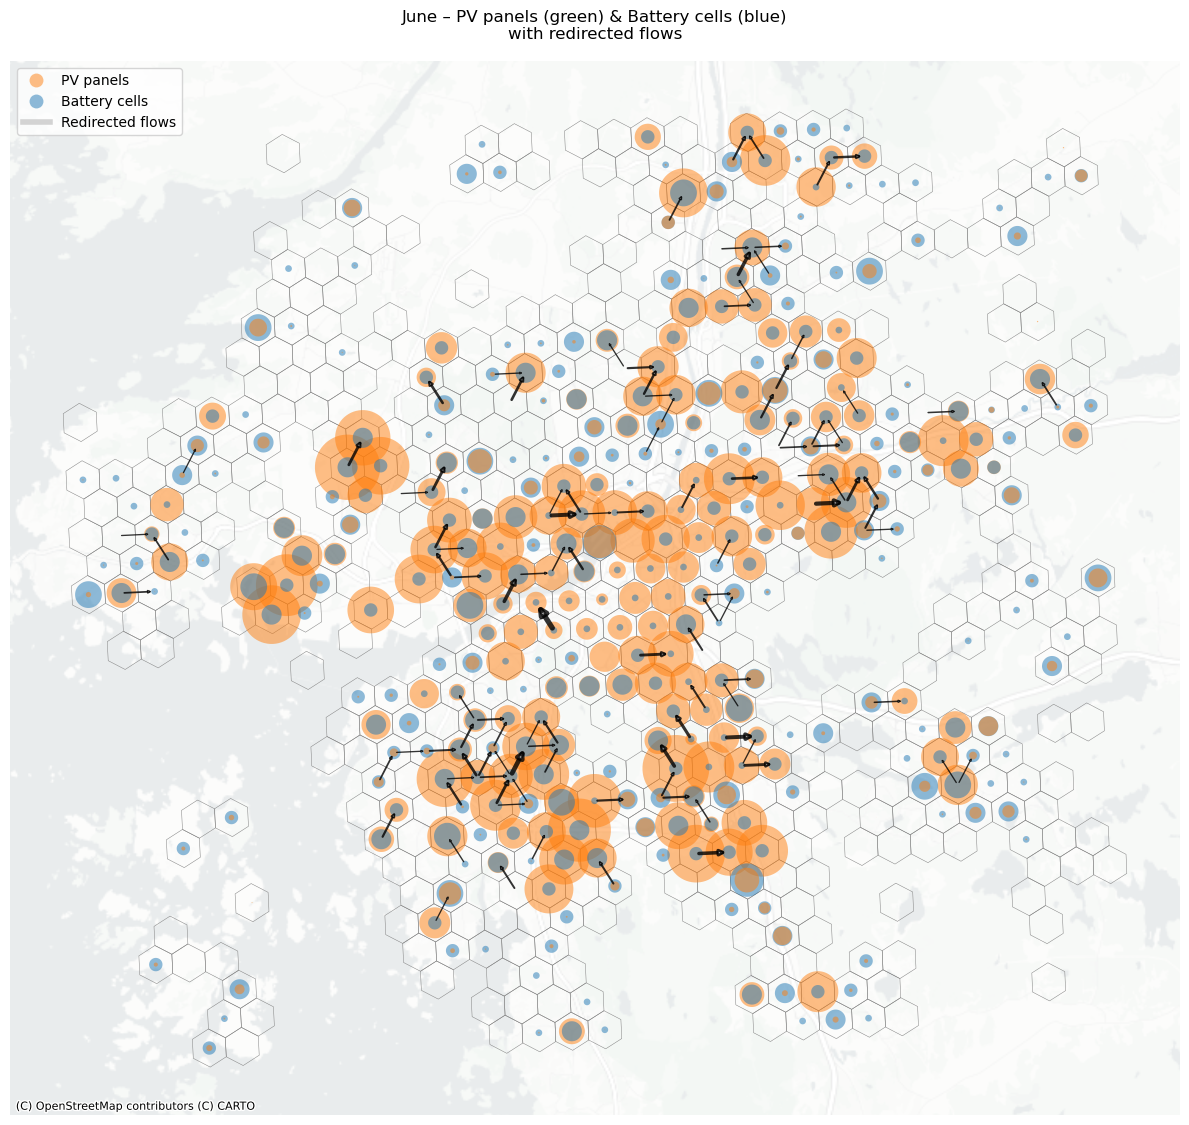

In [12]:
# PV & Battery bubbles   +   June redirection arrows

shp_path    = shapefileDemands
export_xlsx = output_filename

hex_gdf = (
    gpd.read_file(shp_path)[["HexID","geometry"]]
       .astype({"HexID":int})
       .drop_duplicates(subset="HexID")
)
infra = (
    pd.read_excel(export_xlsx, sheet_name="Infrastructure")
      .astype({"HexID":int})
      .loc[:, ["HexID","PV_Panels","Batt_Cells"]]
)
merged = hex_gdf.merge(infra, on="HexID", how="left").fillna(0.0)
merged["cx"] = merged.geometry.centroid.x
merged["cy"] = merged.geometry.centroid.y

BASE_RAD     = 700
BUBBLE_ALPHA = 0.5

bubble_specs = {
    "PV_Panels":   {"color":"#ff7f0e","scale":1.25},
    "Batt_Cells":  {"color":"#1f77b4","scale":1.25*0.5},
}

# compute safe maxima
max_cnt = {
    col: (merged[col].max() if col in merged.columns else 0) or 1
    for col in bubble_specs
}

rows = []
for _, row in merged.iterrows():
    for col, spec in bubble_specs.items():
        n = row[col]
        if n <= 0:
            continue
        r = BASE_RAD * (n / max_cnt[col]) * spec["scale"]
        rows.append({
            "geometry": Point(row.cx, row.cy).buffer(r),
            "facecolor": to_rgba(spec["color"], BUBBLE_ALPHA),
            "edgecolor": "none",
            "z": r
        })

bubbles_gdf = gpd.GeoDataFrame(rows, crs=merged.crs)
bubbles_gdf = bubbles_gdf.sort_values("z", ascending=False)  # largest first

flows = (
    pd.read_excel(export_xlsx, sheet_name="Redirection Flows",
                  usecols=["Month","from_HexID","to_HexID","Energy_kWh"])
      .query("Month == 'June'")
      .groupby(["from_HexID","to_HexID"], as_index=False)
      .agg(kWh_day=("Energy_kWh","sum"))
)

cent = merged.set_index("HexID")[["cx","cy"]]
flows["fx"] = flows["from_HexID"].map(cent.cx)
flows["fy"] = flows["from_HexID"].map(cent.cy)
flows["tx"] = flows["to_HexID"].map(cent.cx)
flows["ty"] = flows["to_HexID"].map(cent.cy)
max_flow = flows.kWh_day.max() or 1.0
gdf3857     = merged.to_crs(epsg=3857)
bubbles3857 = bubbles_gdf.to_crs(epsg=3857)

pts_f = gpd.GeoSeries(
    [Point(x,y) for x,y in flows[["fx","fy"]].to_numpy()],
    crs=merged.crs
).to_crs(epsg=3857)
pts_t = gpd.GeoSeries(
    [Point(x,y) for x,y in flows[["tx","ty"]].to_numpy()],
    crs=merged.crs
).to_crs(epsg=3857)
flows["fxm"], flows["fym"] = pts_f.x.values, pts_f.y.values
flows["txm"], flows["tym"] = pts_t.x.values, pts_t.y.values

fig, ax = plt.subplots(figsize=(12,12))
gdf3857.boundary.plot(ax=ax, color="gray", linewidth=0.35)

for _, bub in bubbles3857.iterrows():
    ax.add_patch(plt.Polygon(
        np.array(bub.geometry.exterior.coords),
        facecolor=bub.facecolor,
        edgecolor=bub.edgecolor,
        linewidth=0,
        zorder=2
    ))

for _, r in flows.iterrows():
    if (r.fxm == r.txm) and (r.fym == r.tym):
        continue
    lw = 0.8 + 3*(r.kWh_day/max_flow)
    arr = FancyArrowPatch(
        (r.fxm, r.fym), (r.txm, r.tym),
        arrowstyle="-|>",
        linewidth=lw,               # outline width
        edgecolor="black",          # black border
        facecolor="lightgray",      # fill
        mutation_scale=lw*3,
        alpha=0.8,
        zorder=3
    )
    ax.add_patch(arr)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.PositronNoLabels,
    crs=gdf3857.crs,
    alpha=0.5
)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "June – PV panels (green) & Battery cells (blue)\nwith redirected flows",
    pad=16
)

leg = [
    Line2D([], [], marker='o', ms=10, lw=0,
           markerfacecolor=to_rgba("#ff7f0e",BUBBLE_ALPHA),
           markeredgecolor='none', label="PV panels"),
    Line2D([], [], marker='o', ms=10, lw=0,
           markerfacecolor=to_rgba("#1F77B4",BUBBLE_ALPHA),
           markeredgecolor='none', label="Battery cells"),
    Line2D([], [], color='lightgray', lw=4, markeredgecolor='black',
           label="Redirected flows")
]
ax.legend(handles=leg, loc="upper left", frameon=True)
plt.tight_layout()
plt.savefig("PV_BattJuneRedir.png", dpi=1200, bbox_inches="tight")
plt.show()

In [18]:
shp_parking  = "full/CharParkfull.shp" 
results_xlsx = output_filename    
out_gpkg     = Path("OptiAnnual.gpkg") 

gdf_base = (gpd.read_file(shp_parking)[["HexID", "geometry"]].assign(HexID=lambda d: d.HexID.astype(int)))
df_infra = (pd.read_excel(results_xlsx, sheet_name="Infrastructure").astype({"HexID": int}))

gdf = gdf_base.merge(df_infra, on="HexID", how="left").fillna(0)
rename_map = {c: (c[:10] if len(c) > 10 else c) for c in gdf.columns}
gdf_shp    = gdf.rename(columns=rename_map)

out_shp = Path("OptiAnnual_assets.shp")
gdf_shp.to_file(out_shp, driver="ESRI Shapefile")
print(f"Written shapefile with asset counts ➜ {out_shp.resolve()}")

Written shapefile with asset counts ➜ C:\Users\omkarp\Downloads\halfHour\Data\OptiAnnual_assets.shp
